In [1]:
import numpy as np
import pandas as pd
import csv
from PIL import Image
import time
import cv2
from sklearn.utils import shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [23]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers.core import Dropout, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dense
from keras.initializers import TruncatedNormal
from keras.regularizers import l1, l2
from keras.utils import to_categorical

In [3]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
# from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
# from keras_preprocessing.image import ImageDataGenerator

In [4]:
import pydicom
from pydicom.data import get_testdata_files

In [5]:
train_filepath = "dataset/RSNA_training_processed.csv"
df = pd.read_csv(train_filepath)
df.shape

(674262, 7)

In [6]:
lines = []
d = dict()
for file in ['RSNA0', 'RSNA1', 'RSNA2', 'RSNA3', 'RSNA4', 'RSNA5']:
# for file in ['RSNA0', 'RSNA2']:
    with open( 'dataset/' + file + '.csv') as f:
        path_lines = f.read().splitlines()
        for i in range(len(path_lines)):
            path_lines[i] = path_lines[i].split(".")[0]
    lines = lines + path_lines
    d[file] = set(path_lines)
    print(path_lines[0])


ID_63eb1e259
ID_e732e6d17
ID_2124519bc
ID_fac4426fa
ID_5fc337950
ID_aeda0804d


In [7]:
len(lines)

6000

In [8]:
d.keys()

dict_keys(['RSNA0', 'RSNA1', 'RSNA2', 'RSNA3', 'RSNA4', 'RSNA5'])

In [9]:
line = lines[0]
print(line)
lin = line.split(".")[0]
print(lin)

ID_63eb1e259
ID_63eb1e259


In [10]:
for i, line in enumerate(lines):
    lines[i] = line.split(".")[0]

In [11]:
sample_df = df.loc[df['ID'].isin(lines)]

In [12]:
# tdf = sample_df[:10]
for i, row in sample_df.iterrows():
    filename = row['ID']
    for key in d.keys():
        if filename in d[key]:
            sample_df.at[i,'ID'] = key + '/' + filename

In [13]:
sample_df.shape

(6000, 7)

In [14]:
sample_df_shuffled = shuffle(sample_df)

In [15]:
# sample_df_shuffled.reset_index(inplace=True, drop=True)
sample_df_shuffled.head()

,ID,1,2,3,4,5,label
286,RSNA0/ID_aa8d466d4,0,0,0,0,0,0
43285,RSNA3/ID_f805c5ba4,0,0,1,0,0,1
30132,RSNA4/ID_5c5bf9ff9,0,0,0,1,0,1
17587,RSNA2/ID_c1f3703f5,0,1,0,0,0,1
32327,RSNA2/ID_1bcd3ba21,0,1,0,0,0,1


In [16]:
splitdf_index1 = round(0.8 * len(sample_df_shuffled))
print(splitdf_index1)

train_df = sample_df_shuffled[ : splitdf_index1]
validate_df = sample_df_shuffled[splitdf_index1 : ]

4800


In [17]:
x = sample_df_shuffled.iloc[6]
print(x)
classfinder(x)

ID       RSNA0/ID_8f276c3f7
 1                        0
2                         0
3                         0
4                         0
5                         0
label                     0
Name: 1161, dtype: object


NameError: name 'classfinder' is not defined

In [18]:
# train_list = train_df[train_df.columns[0]].tolist()
# validate_list = validate_df[validate_df.columns[0]].tolist()
# train_label_list = train_df[train_df.columns[6]].tolist()
# validate_label_list = validate_df[validate_df.columns[6]].tolist()

In [19]:
%load_ext cython

In [20]:
%%cython -a
import cython

@cython.boundscheck(False)
cpdef float[:, :] threshold_fast(int T1, int T2, float [:, :] image):
    # set the variable extension types
    cdef int x, y, w, h
    
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            image[y, x] = image[y, x] if (image[y, x] >= T1 and image[y, x] <= T2) else 0
    
    # return the thresholded image
    return image

In [35]:
def classfinder(df):
    for i in range(1,6):
        if df[i] == 1:
            return i
    return 0
            
def window_image_reg(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

# generates batches of images to be fed into the model
def myGenerator(image_df, batch_size):
    num_samples = image_df.shape[0]
    X_return = []
    y_return = []
    
    while True:
        for offset in range(0, num_samples, batch_size):
            images = []
            labels = []
            temp_df = image_df[offset:offset+int(batch_size)]

            for index in range(0, temp_df.shape[0]):
                source_path = temp_df.iloc[index]['ID']
                
                filename = 'dataset/' + source_path + '.dcm'
                
                # Load the image
                try:
                    ds = pydicom.dcmread(filename)
                except:
                    continue
                # get pixel values from the read DICOM file
                image_single = ds.pixel_array
                
                # perform windowing
                window_center , window_width, intercept, slope = get_windowing(ds)
                image_windowed = window_image(image_single, window_center, window_width, intercept, slope)
                
                #  resize the image
                image_windowed_float = image_windowed.astype(np.float32)
                image_windowed_resized = cv2.resize(image_windowed_float, dsize=(224, 224))
                
                # thresholding to include hounsfield values for blood
#                 thresh = threshold_fast(40, 66, image_windowed_resized)
                
                # stack thrice for 3 channels
#                 image = np.stack([thresh, thresh, thresh])
                image = np.stack([image_windowed_resized, image_windowed_resized, image_windowed_resized])

                
                # converting to channels_last
                image = np.moveaxis(image, 0, 2)

                images.append(image)
                
                label = to_categorical(classfinder(temp_df.iloc[index]), num_classes=6)
                labels.append(label)


            X_return = np.asarray(images)
            y_return = np.asarray(labels)

            yield shuffle(X_return, y_return)


This cell is for looking at the DICOM files

In [47]:
# Constants
TEST_SIZE = 0.02
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
SHAPE = (HEIGHT, WIDTH, CHANNELS)

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

dataset/RSNA3/ID_738db51ab.dcm


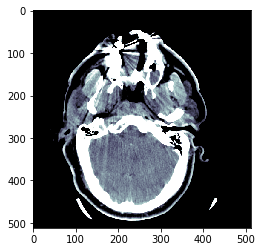

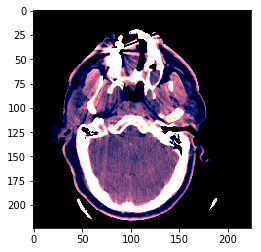

In [53]:
# source_path = train_list[2] # use index 2 to for the image P wants
# for line in validate_df[503:504]:
line = validate_df.iloc[16]
# print(line)
filename = 'dataset/' + line[0] + '.dcm'
current_path = filename
print(current_path)

ds = pydicom.dcmread(filename)

image_single = ds.pixel_array
window_center , window_width, intercept, slope = get_windowing(ds)
image_windowed = window_image_reg(image_single, window_center, window_width, intercept, slope)

# # Convert to uint
# image_2d_scaled = np.uint8(image_2d_scaled)

plt.figure()
plt.imshow(image_windowed, cmap = plt.cm.bone)

# image_windowed_float = image_windowed.astype(np.float32)

# image_windowed_resized = cv2.resize(image_windowed_float, dsize=(224, 224))

# thresholding to include hounsfield values from -150 to +150    

# thresh = threshold_fast(40, 66, image_windowed_resized)  
# plt.figure()
# plt.imshow(thresh, cmap =plt.cm.bone) 

#     print(type(np.array(thresh)))
# thresh1 = cv2.dilate(np.array(thresh), None, iterations=3)
# thresh1 = cv2.erode(np.array(thresh1), None, iterations=4)

image_bsb = bsb_window(ds)
plt.figure()
plt.imshow(image_bsb, cmap = plt.cm.bone)

# plt.figure()
# plt.imshow(thresh1, cmap =plt.cm.bone) 

#     savefile_name = "images/" + source_path + ".png"
#     plt.imsave(savefile_name, ds.pixel_array, cmap='gray')

In [52]:
a = np.array([[1,2,3],[4,5,6], [7,8,9]])
a = a.astype(np.float32)
a

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]], dtype=float32)

In [96]:
b = cv2.resize(a, dsize=(2, 2))
b

array([[2. , 3.5],
       [6.5, 8. ]], dtype=float32)

In [36]:
np.savetxt('image_windowed.txt', image_windowed)
np.savetxt('image_windowed_single.txt', image_windowed_single)

In [65]:
np.min(image_windowed)

76

In [66]:
np.min(image_windowed_resized)

0

In [14]:
validate_df.head()

,ID,1,2,3,4,5,label
3478,RSNA0EXT/ID_d2d243c32,0,0,0,0,0,0
30340,RSNA2/ID_db79c02f9,0,1,0,0,0,1
3331,RSNA0EXT/ID_8301f4b60,0,0,0,0,0,0
7500,RSNA5/ID_2077e39ca,0,0,0,0,1,1
12025,RSNA5/ID_63b3ee44c,0,0,0,0,1,1


In [18]:
from keras.applications.vgg16 import VGG16


Load a predefined model into 'base_model'

In [18]:
base_model = keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
                                                         include_top=False, weights='imagenet', input_tensor=None, 
                                                         pooling=None)

In [19]:
for layer in base_model.layers: 
    layer.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x) # GAP

x = Dropout(0.5)(x)

x = Dense(500)(x)               # Dense 1
x = Activation('relu')(x)

x = Dropout(0.5)(x)

x = Dense(200)(x)               # Dense 2
x = Activation('relu')(x)

x = Dropout(0.5)(x)

x = Dense(50)(x)               # Dense 3
x = Activation('relu')(x)

x = Dropout(0.5)(x)

predictions = Dense(6, activation='softmax')(x) # Dense 4

model_PrashNet = Model(inputs=base_model.input, outputs=predictions)

model_PrashNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
sgd = SGD(lr=0.001, momentum=0.9, decay=1e-6, nesterov=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_PrashNet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

timeasname = time.asctime(time.localtime(time.time())).replace(" ", "-").replace(":", "-")
modelname = "inception-all"
weights = "imagenet"
optimizer= "sgd"
specs = modelname + '_' + weights + '_' + optimizer
weight_path="weights/{}_{}_weights.best.hdf5".format(specs, timeasname)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, verbose = 1,min_lr = 1e-7)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

# tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(timeasname),
#                                           histogram_freq=0, write_graph=True, write_images=True)

# csvlogger = keras.callbacks.CSVLogger("epochlogs/{}_{}".format(specs, timeasname), separator=',', append=False)                                          
                                          
earlyStop = EarlyStopping(monitor='val_acc',min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

# callbacks_list = [checkpoint, reduce_lr, tensorboard, csvlogger]
# callbacks_list = [checkpoint, reduce_lr, csvlogger]
callbacks_list = [checkpoint, reduce_lr, earlyStop]

In [25]:
batch_size = 64

train_gen = myGenerator(train_df, batch_size)
valid_gen = myGenerator(validate_df, batch_size)

In [26]:
hist = model_PrashNet.fit_generator(train_gen,
                           int((len(train_df))/batch_size),
                           epochs = 50, verbose=1, 
                           callbacks=callbacks_list,
                           validation_data = valid_gen,
                           validation_steps = int((len(validate_df))/batch_size))

Epoch 1/50
75/75 [==============================] - 177s 2s/step - loss: 2.0397 - acc: 0.1790 - val_loss: 1.7800 - val_acc: 0.2127

Epoch 00001: val_loss improved from inf to 1.78004, saving model to weights/inception-all_imagenet_sgd_Mon-Nov-25-19-54-05-2019_weights.best.hdf5
Epoch 2/50
75/75 [==============================] - 61s 819ms/step - loss: 1.8117 - acc: 0.1781 - val_loss: 1.7752 - val_acc: 0.2405

Epoch 00002: val_loss improved from 1.78004 to 1.77521, saving model to weights/inception-all_imagenet_sgd_Mon-Nov-25-19-54-05-2019_weights.best.hdf5
Epoch 3/50
75/75 [==============================] - 63s 841ms/step - loss: 1.7783 - acc: 0.2119 - val_loss: 1.7588 - val_acc: 0.2847

Epoch 00003: val_loss improved from 1.77521 to 1.75880, saving model to weights/inception-all_imagenet_sgd_Mon-Nov-25-19-54-05-2019_weights.best.hdf5
Epoch 4/50
75/75 [==============================] - 62s 832ms/step - loss: 1.7484 - acc: 0.2265 - val_loss: 1.7195 - val_acc: 0.3099

Epoch 00004: val_los

# Cells below here are for experiments

Save weights if you want

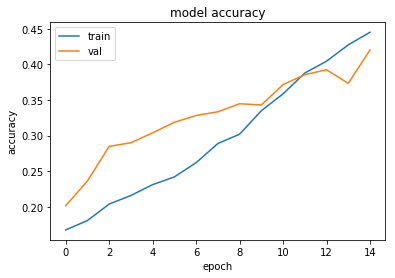

In [29]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

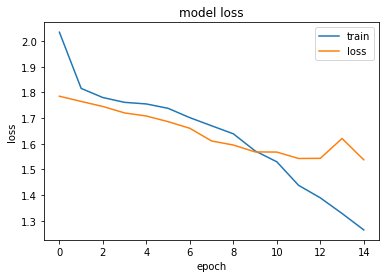

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper right')
plt.show()

In [104]:
timeasname = time.asctime(time.localtime(time.time())).replace(" ", "-").replace(":", "-")
modelname = "inception-0-1"
weights = "imagenet"
optimizer= "adam"
specs = modelname + '_' + weights + '_' + optimizer
weight_path="weights/{}_{}_weights.best.hdf5".format(specs, timeasname)

In [105]:
model_PrashNet.save_weights(weight_path)

load weights - inception

In [26]:
model_PrashNet.load_weights("weights/inceptionv3_adam_imagenet_11_22_2019.hdf5")

In [106]:
# test_data = validate_df.
testinfo_df = validate_df.copy(deep=True)
# testinfo_df['GroundTruth'] = ""
# testinfo_df['Predicted'] = ""


In [107]:
testinfo_df.shape

(400, 7)

In [108]:
no_of_lines = len(testinfo_df)
# no_of_lines = 200
gt = []
preds = []
probs = []
cgt, cprobs = [], []
count, c2 = 0, 0
for index in range(0, no_of_lines):
    source_path = testinfo_df.iloc[index]['ID']
    filename = 'dataset/' + source_path + '.dcm'
    try:
        ds = pydicom.dcmread(filename)
    except:
        continue
    image_single = ds.pixel_array
    window_center , window_width, intercept, slope = get_windowing(ds)
    image_windowed = window_image(image_single, window_center, window_width, intercept, slope)
    image_windowed_float = image_windowed.astype(np.float32)
    image_windowed_resized = cv2.resize(image_windowed_float, dsize=(224, 224))
#     thresh = threshold_fast(40, 66, image_windowed_resized)
    image = np.stack([image_windowed_resized, image_windowed_resized, image_windowed_resized])
    image = np.moveaxis(image, 0, 2)            
    X = model_PrashNet.predict(np.array(image, ndmin = 4))
#     print(X)
    predicted_prob = np.max(X)
    predicted_class = np.argmax(X)
#     print("predicted class: ", predicted_class)
    actual_class = classfinder(testinfo_df.iloc[index])
#     print("actual class: ", actual_class)
#     testinfo_df.at[index, "GroundTruth"] = actual_class
#     testinfo_df.at[index, 'Predicted'] = predicted_class
    preds.append(predicted_class)
    gt.append(actual_class)
    probs.append(predicted_prob)
    if predicted_class == actual_class:
        count = count + 1
        cprobs.append(predicted_prob)
        cgt.append(actual_class)
#         if predicted_prob > 0.75:
#             cprobs.append(predicted_prob)
#             cgt.append(actual_class)
            
print(count, c2, no_of_lines, count/no_of_lines)

345 0 400 0.8625


In [51]:
import scikitplot as skplt

In [109]:
len(preds)

400

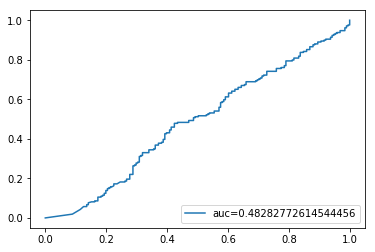

0.48282772614544456


In [110]:
fpr, tpr, thresholds = metrics.roc_curve(gt, probs)
auc = metrics.roc_auc_score(gt,probs)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(auc)

In [111]:
cnf_matrix = metrics.confusion_matrix(preds, gt)

In [112]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.82380952 0.17619048]
 [0.09473684 0.90526316]]


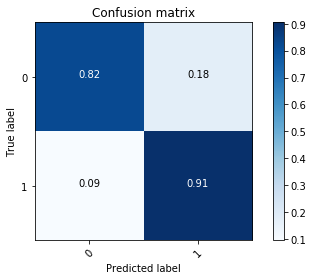

In [113]:
plt.figure()
class_list = list(range(2))
plot_confusion_matrix(cnf_matrix, classes=class_list, normalize=True)

In [ ]:
array_path="{}_{}.txt".format(specs, timeasname)
np.savetxt('arrays/preds' + '_' + array_path, preds)
np.savetxt('arrays/probs' + '_' + array_path, probs)
np.savetxt('arrays/gt' + '_' + array_path, gt)
np.savetxt('arrays/cprobs' + '_' + array_path, cprobs)
np.savetxt('arrays/cgt' + '_' + array_path, cgt)

Saving intermediate layer output to a pkl file

In [48]:
layer_name = 'global_average_pooling2d_1'
intermediate_layer_model = Model(inputs=model_PrashNet.input,
                                 outputs=model_PrashNet.get_layer(layer_name).output)

In [80]:
temp_df = validate_df.copy()
temp_df['Inter_op'] = ""
temp_df['class'] = ""

In [81]:
temp_df.head()

,ID,1,2,3,4,5,label,Inter_op,class
252,RSNA0/ID_ea65a8ad0,0,0,0,0,0,0,,
26197,RSNA2/ID_20b9eac20,0,1,0,0,0,1,,
1752,RSNA3/ID_3aaaf8cd6,0,0,1,0,0,1,,
42863,RSNA3/ID_5fcb747c0,0,0,1,0,0,1,,
2696,RSNA3/ID_27dd8ab3a,0,0,1,0,0,1,,


In [82]:
no_of_lines = len(temp_df)
# no_of_lines = 2

for index in range(0, no_of_lines):
    source_path = temp_df.iloc[index]['ID']
    filename = 'dataset/' + source_path + '.dcm'
    try:
        ds = pydicom.dcmread(filename)
    except:
        continue
    image_single = ds.pixel_array
    window_center , window_width, intercept, slope = get_windowing(ds)
    image_windowed = window_image(image_single, window_center, window_width, intercept, slope)
    image_windowed_float = image_windowed.astype(np.float32)
    image_windowed_resized = cv2.resize(image_windowed_float, dsize=(224, 224))
#     thresh = threshold_fast(40, 66, image_windowed_resized)
    image = np.stack([image_windowed_resized, image_windowed_resized, image_windowed_resized])
    image = np.moveaxis(image, 0, 2)            
    X = intermediate_layer_model.predict(np.array(image, ndmin = 4))

    actual_class = classfinder(temp_df.iloc[index])
#     print(filename, actual_class, type(X), X.size)
    temp_df.iat[index, 8] = actual_class
    temp_df.iat[index, 7] = X
            

In [69]:
export_df = temp_df.copy()

In [70]:
export_df.head()

,ID,1,2,3,4,5,label,Inter_op,class
35032,RSNA4/ID_352b3ae8e,0,0,0,1,0,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4
795,RSNA0/ID_82e2004a0,0,0,0,0,0,0,"[[0.4198561, 0.0, 0.0, 0.0, 0.44340202, 0.0002...",0
15844,RSNA5/ID_0db6d4271,0,0,0,0,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5
143678,RSNA1/ID_27dd8ecb4,1,0,0,0,0,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
416928,RSNA1/ID_3b48698b8,1,0,0,0,0,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [74]:
export_df.columns

Index(['ID', ' 1', '2', '3', '4', '5', 'label', 'Inter_op', 'class'], dtype='object')

In [77]:
export_df = export_df.drop(columns=[' 1','2','3','4','5', 'label'])

In [79]:
sub = export_df.to_pickle("train_multiclass.pkl")